In [202]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import SQLContext
import pyspark.sql.functions as func
from pyspark import SparkContext
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
import pandas as pd
import seaborn as sns
sns.set()


spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
sc = spark.sparkContext

# Import Data
yearSuicide = spark.read.csv("hdfs://namenode/year_suicide_rates.csv", header=True, inferSchema=True)
gdp = spark.read.csv("hdfs://namenode/gdp_rank.csv", header=True, inferSchema=True)
suicideRate = spark.read.csv("hdfs://namenode/suicide_rates.csv", header=True, inferSchema=True)
countrySuicide = spark.read.csv("hdfs://namenode/suicide-rates-country.csv", header=True, inferSchema=True)
genderSuicide = spark.read.csv("hdfs://namenode/Male-Female-Ratio-of-Suicide.csv", header=True, inferSchema=True)
four_countries_gdp = spark.read.csv("hdfs://namenode/four_countries_gdp.csv", header=True, inferSchema=True)
ageGroupSuicide = spark.read.csv("hdfs://namenode/suicide-age-group-2012-2017.csv", header=True, inferSchema=True)
annual_self_harm_number = spark.read.csv("hdfs://namenode/annual-number-deaths-by-cause.csv", header=True, inferSchema=True)

# Create Temporary Tables
annual_self_harm_number.createOrReplaceTempView("annual_self_harm_number")
four_countries_gdp.createOrReplaceTempView("four_countries_gdp")
gdp.createOrReplaceTempView("gdp")
yearSuicide.createOrReplaceTempView("yearSuicide")
suicideRate.createOrReplaceTempView("suicideRate")
countrySuicide.createOrReplaceTempView("countrySuicide")
genderSuicide.createOrReplaceTempView("genderSuicide")
ageGroupSuicide.createOrReplaceTempView("ageGroupSuicide")

gdp_pd = pd.read_csv("gdp_rank.csv")
suicide_sex_ratios = pd.read_csv("Male-Female-Ratio-of-Suicide.csv")
suicide_country = pd.read_csv("suicide-rates-country.csv")

# Analyze data about global population of different death causes

In [203]:
annual_self_harm_number.printSchema()

root
 |-- Entity: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Number of executions (Amnesty International): string (nullable = true)
 |-- Deaths - Meningitis - Sex: Both - Age: All Ages (Number): double (nullable = true)
 |-- Deaths - Lower respiratory infections - Sex: Both - Age: All Ages (Number): double (nullable = true)
 |-- Deaths - Intestinal infectious diseases - Sex: Both - Age: All Ages (Number): double (nullable = true)
 |-- Deaths - Protein-energy malnutrition - Sex: Both - Age: All Ages (Number): double (nullable = true)
 |-- Terrorism (deaths): integer (nullable = true)
 |-- Deaths - Cardiovascular diseases - Sex: Both - Age: All Ages (Number): double (nullable = true)
 |-- Deaths - Alzheimer disease and other dementias - Sex: Both - Age: All Ages (Number): double (nullable = true)
 |-- Deaths - Chronic kidney disease - Sex: Both - Age: All Ages (Number): double (nullable = true)
 |-- Deaths - Chronic respiratory 

Rename columns with long texts(only for those columns which will be used)

In [204]:
annual_death_causes = annual_self_harm_number.withColumnRenamed("Deaths - Meningitis - Sex: Both - Age: All Ages (Number)", "Death from meningitis")\
                                            .withColumnRenamed("Deaths - Lower respiratory infections - Sex: Both - Age: All Ages (Number)","Death from lower respiratory")\
                                            .withColumnRenamed("Deaths - Intestinal infectious diseases - Sex: Both - Age: All Ages (Number)","Death from intestinal infectious diseases")\
                                            .withColumnRenamed("Deaths - Protein-energy malnutrition - Sex: Both - Age: All Ages (Number)","Death from protein-energy malnutrition")\
                                            .withColumnRenamed("Terrorism (deaths)", "Death from terrorism")\
                                            .withColumnRenamed("Deaths - Road injuries - Sex: Both - Age: All Ages (Number)","Death from road injuries")\
                                            .withColumnRenamed("Deaths - Alcohol use disorders - Sex: Both - Age: All Ages (Number)","Death from alcohol use disorders")\
                                            .withColumnRenamed("Deaths - Fire, heat, and hot substances - Sex: Both - Age: All Ages (Number)","Death from fire and hot")\
                                            .withColumnRenamed("Deaths - Self-harm - Sex: Both - Age: All Ages (Number)","Death from self-harm")\
                                            .withColumnRenamed("Deaths - Digestive diseases - Sex: Both - Age: All Ages (Number)", "Death from digestive diseases")\
                                            .withColumnRenamed("Deaths - HIV/AIDS - Sex: Both - Age: All Ages (Number)", "Death from HIV/AIDS")\
                                            .withColumnRenamed("Deaths - Digestive diseases - Sex: Both - Age: All Ages (Number)", "Death from digestive diseases")
annual_death_causes_less = annual_death_causes.select("Entity", "Code", "Year", "Death from meningitis", "Death from lower respiratory","Death from intestinal infectious diseases", "Death from protein-energy malnutrition", 
                              "Death from road injuries", "Death from terrorism","Death from alcohol use disorders", "Death from fire and hot", "Death from self-harm", "Death from HIV/AIDS", "Death from digestive diseases")
annual_death_causes_less.show()

+-----------+----+----+---------------------+----------------------------+-----------------------------------------+--------------------------------------+------------------------+--------------------+--------------------------------+-----------------------+--------------------+-------------------+-----------------------------+
|     Entity|Code|Year|Death from meningitis|Death from lower respiratory|Death from intestinal infectious diseases|Death from protein-energy malnutrition|Death from road injuries|Death from terrorism|Death from alcohol use disorders|Death from fire and hot|Death from self-harm|Death from HIV/AIDS|Death from digestive diseases|
+-----------+----+----+---------------------+----------------------------+-----------------------------------------+--------------------------------------+------------------------+--------------------+--------------------------------+-----------------------+--------------------+-------------------+-----------------------------+
|Afghanist

In [205]:
annual_df = annual_death_causes_less.toPandas()
annual_df

,Entity,Code,Year,Death from meningitis,Death from lower respiratory,Death from intestinal infectious diseases,Death from protein-energy malnutrition,Death from road injuries,Death from terrorism,Death from alcohol use disorders,Death from fire and hot,Death from self-harm,Death from HIV/AIDS,Death from digestive diseases
0,Afghanistan,AFG,2007,9121.085992,29066.442137,461.195202,1846.996686,8099.404950,1199.0,96.027592,498.392147,1378.571549,144.503747,4922.241281
1,Afghanistan,AFG,2008,8387.057275,26623.480551,437.718960,1681.270324,8038.390392,1092.0,98.308461,476.394809,1411.783229,153.260211,4876.682148
2,Afghanistan,AFG,2009,7318.273004,24792.335792,415.776634,1568.095029,7879.711037,1065.0,100.088778,455.525522,1428.808015,158.886080,4825.603053
3,Afghanistan,AFG,2011,6919.757958,23115.144836,299.758258,1468.203744,8051.536317,1525.0,105.565020,457.993531,1496.192418,176.560292,4850.470080
4,Afghanistan,AFG,2012,6631.942601,22155.754481,302.255411,1406.214788,8057.220489,3521.0,108.281688,452.439442,1528.384710,186.238565,4851.890548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6681,Zimbabwe,ZWE,2013,1820.090331,13108.151347,25.015658,3507.171892,2769.257442,1.0,73.649954,620.024209,2561.496069,31808.820281,3290.553727
6682,Zimbabwe,ZWE,2014,1769.993458,12841.510671,25.623337,3380.319464,2728.371376,0.0,73.460128,609.387024,2554.170577,24602.870777,3284.347650
6683,Zimbabwe,ZWE,2015,1728.691503,12637.728613,25.415872,3263.941226,2725.852725,NaN,74.605887,599.262647,2583.031015,20841.883197,3303.600304
6684,Zimbabwe,ZWE,2016,1703.437894,12495.147292,25.752116,3188.723249,2731.304860,NaN,75.907792,596.297688,2619.243794,18491.624779,3345.340586


Show 'Death from self-harm' population ranking in 2005

In [206]:
# Dismiss all "NAN"  and "null" value
annual_selfharm = annual_death_causes_less.orderBy("Death from self-harm", ascending=False)
annual_selfharm_2005 = annual_selfharm.filter("Year == '2005'").select("Entity", "Code", "Year", "Death from self-harm").na.drop()
annual_selfharm_2005.toPandas()

,Entity,Code,Year,Death from self-harm
0,World,OWID_WRL,2005,805645.304159
1,India,IND,2005,188140.423401
2,China,CHN,2005,152878.243310
3,Russia,RUS,2005,75956.955569
4,United States,USA,2005,38876.995647
...,...,...,...,...
191,Sao Tome and Principe,STP,2005,3.657706
192,American Samoa,ASM,2005,3.162036
193,Dominica,DMA,2005,2.971506
194,Bermuda,BMU,2005,2.967454


In [207]:
# Delete the first row which is a sum result from the overall world 
annual_selfharm_2005=annual_selfharm_2005.filter("Entity != 'null' AND Entity != 'World'")
annual_selfharm_2005.toPandas()

,Entity,Code,Year,Death from self-harm
0,India,IND,2005,188140.423401
1,China,CHN,2005,152878.243310
2,Russia,RUS,2005,75956.955569
3,United States,USA,2005,38876.995647
4,Japan,JPN,2005,33925.690351
...,...,...,...,...
190,Sao Tome and Principe,STP,2005,3.657706
191,American Samoa,ASM,2005,3.162036
192,Dominica,DMA,2005,2.971506
193,Bermuda,BMU,2005,2.967454


# View the trend of the suicide population changes of 8 countries whose GDP are in top-8 among different years

Merge GDP table to suicide rate table

In [208]:
# Merge countrySuicide to gdp and choose top ten countries according to GDP ranking
merge_results = spark.sql("  \
    select c.Entity as Country, c.Code, c.suicideRate, p.Ranking, p.GDP as GDP \
    from gdp p\
              inner join countrySuicide c\
                              on c.Code = p.Code \
    where c.Year = '2005' \
    ")

merge_df = merge_results.na.drop().toPandas()
merge_df.sort_values(by='Ranking', ascending=True).head(10)

,Country,Code,suicideRate,Ranking,GDP
176,United States,USA,9.927033,1,"19,485,394"
35,China,CHN,16.913248,2,"12,237,700"
82,Japan,JPN,18.946930,3,"4,872,415"
62,Germany,DEU,9.211085,4,"3,693,204"
74,India,IND,18.583826,5,"2,650,725"
175,United Kingdom,GBR,6.014659,6,"2,637,866"
58,France,FRA,14.091530,7,"2,582,501"
23,Brazil,BRA,4.777007,8,"2,053,595"
80,Italy,ITA,4.930045,9,"1,943,835"
30,Canada,CAN,10.100990,10,"1,647,120"


Pivot the suicide population table

In [209]:
# Pivot the table of eighht countries' suicide population in different years
annual_four_years = annual_selfharm.filter("Entity != 'World' AND (Year == '2000' OR Year == '2005' OR Year =='2010' OR Year == '2015')")
annual_four_years = annual_four_years.select("Entity", "Year", "Death from self-harm").na.drop()
annual_selfharm_df=annual_four_years.toPandas()
annual_pivot = annual_selfharm_df.pivot(index='Entity', columns='Year', values='Death from self-harm').reset_index().rename_axis(None, axis=1)
annual_pivot

,Entity,2000,2005,2010,2015
0,Afghanistan,1171.900184,1357.231136,1457.157631,1638.922690
1,Albania,150.230471,173.435048,165.199144,163.872850
2,Algeria,1558.659636,1656.079281,1666.087272,1723.495077
3,American Samoa,3.334764,3.162036,3.221195,3.440706
4,Andean Latin America,2497.672050,2872.391436,3269.651129,3190.549501
...,...,...,...,...,...
225,Western Europe,55580.417807,52007.630711,52262.306226,50972.358052
226,Western Sub-Saharan Africa,14953.549071,16374.685269,18552.719659,21036.539108
227,Yemen,926.273701,1063.271921,1199.137052,1363.086259
228,Zambia,811.501039,787.116848,894.367484,1066.530803


Text(0, 0.5, 'Self-harm population')

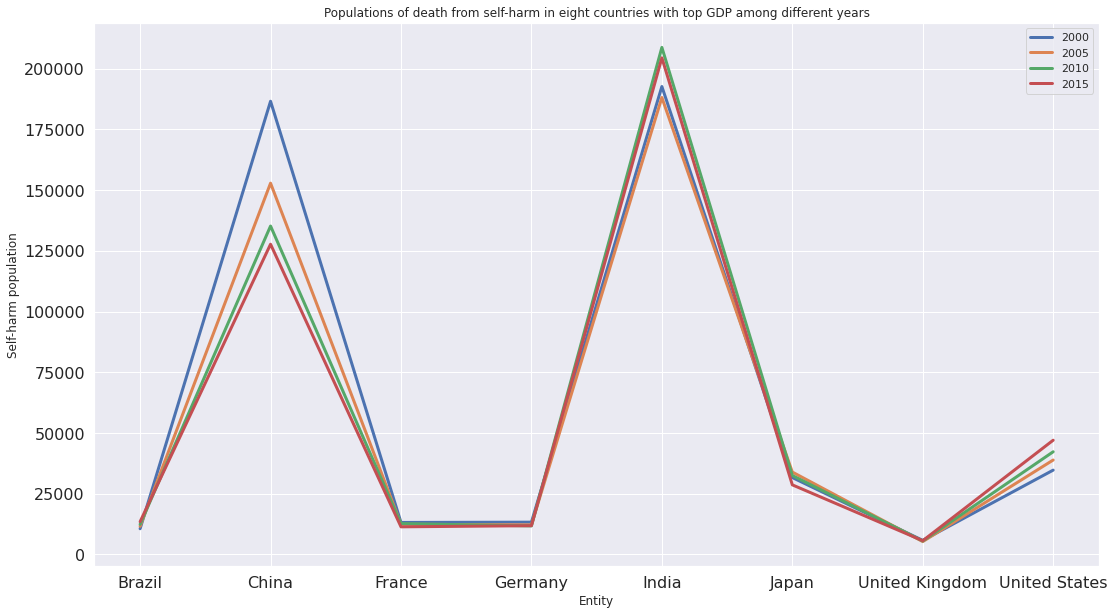

In [210]:
# Study the trend of suicide rate among 8 countries whose GDP is in top 8  in 2000, 2005, 2010, 2015
annual_pivot[(annual_pivot['Entity'] == 'United States')|(annual_pivot['Entity'] == 'China')|(annual_pivot['Entity'] == 'Japan')
             |(annual_pivot['Entity'] == 'Germany')|(annual_pivot['Entity'] == 'India')|(annual_pivot['Entity'] == 'United Kingdom')
             |(annual_pivot['Entity'] == 'France')|(annual_pivot['Entity'] == 'Brazil')].plot(kind='line', x='Entity', figsize=(18,10), 
                                title='Populations of death from self-harm in eight countries with top GDP among different years', lw=3, fontsize=16, grid=True)
plt.ylabel("Self-harm population")

As shown above, red means the most recent year and the blue means the oldest year, the distance between each colored line vertically represents the changed population.
In conclusion, the suicide population of the USA has been increasing and may be going to increase in the future. The suicide population of China has been dereasing and decreased most rapidly.

<AxesSubplot:title={'center':'Suicide population distribution among 8 countries with top GDP in 2005'}, ylabel='Death from self-harm'>

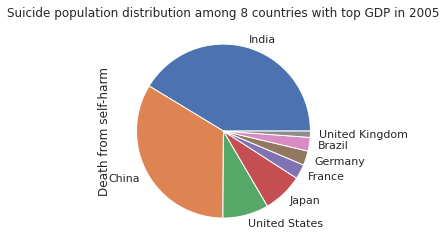

In [211]:
# View the percentage of each country from above figure
avg_df=annual_selfharm_df[(annual_selfharm_df['Year'] == 2005)&((annual_selfharm_df['Entity'] == 'United States')|(annual_selfharm_df['Entity'] == 'China')|(annual_selfharm_df['Entity'] == 'India')
                          |(annual_selfharm_df['Entity'] == 'France')|(annual_selfharm_df['Entity'] == 'Germany')|(annual_selfharm_df['Entity'] == 'Brazil')
                            |(annual_selfharm_df['Entity'] == 'United Kingdom')|(annual_selfharm_df['Entity'] == 'Japan'))]
avg_df.plot(kind='pie', y='Death from self-harm', labels=avg_df['Entity'], legend = False, title='Suicide population distribution among 8 countries with top GDP in 2005')

View suicide rate about these 8 countries

<AxesSubplot:title={'center':'Suicide rate in eight countries with top GDP among different years'}>

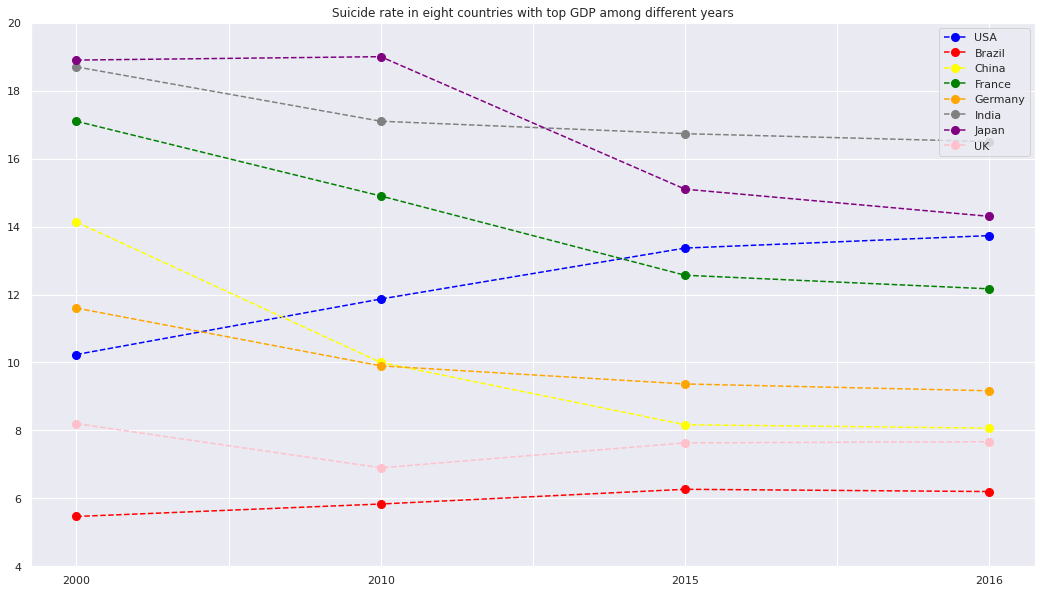

In [212]:
# Comparison of suicide rate between 8 countries whose GDP is in top 8 in 2005
yearSuicide_df = yearSuicide.toPandas()

plt.figure(figsize=(18,10))
plt.ylim(4,20)
plt.title('Suicide rate in eight countries with top GDP among different years')

suicide_USA_pd =yearSuicide.filter("Country == 'United States of America'").toPandas()
suicide_BRA_pd = yearSuicide.filter("Country == 'Brazil'").toPandas()
suicide_CHN_pd = yearSuicide.filter("Country == 'China'").toPandas()
suicide_FRA_pd = yearSuicide.filter("Country == 'France'").toPandas()
suicide_GER_pd = yearSuicide.filter("Country == 'Germany'").toPandas()
suicide_IND_pd = yearSuicide.filter("Country == 'India'").toPandas()
suicide_JPN_pd = yearSuicide.filter("Country == 'Japan'").toPandas()
suicide_UK_pd = yearSuicide.filter("Country == 'United Kingdom of Great Britain and Northern Ireland'").toPandas()


suicide_USA_pd[['2000','2010','2015','2016']].mean().plot(linestyle='dashed',color='blue',
                                        marker='o',markersize=8, legend=True, markerfacecolor='blue', label='USA')
suicide_BRA_pd[['2000','2010','2015','2016']].mean().plot(linestyle='dashed',color='red',
                                        marker='o',markersize=8, legend=True, markerfacecolor='red', label='Brazil')
suicide_CHN_pd[['2000','2010','2015','2016']].mean().plot(linestyle='dashed',color='yellow',
                                        marker='o',markersize=8, legend=True, markerfacecolor='yellow', label='China')
suicide_FRA_pd[['2000','2010','2015','2016']].mean().plot(linestyle='dashed',color='green',
                                        marker='o',markersize=8, legend=True, markerfacecolor='green', label='France')
suicide_GER_pd[['2000','2010','2015','2016']].mean().plot(linestyle='dashed',color='orange',
                                        marker='o',markersize=8, legend=True, markerfacecolor='orange', label='Germany')
suicide_IND_pd[['2000','2010','2015','2016']].mean().plot(linestyle='dashed',color='grey',
                                        marker='o',markersize=8, legend=True, markerfacecolor='grey', label='India')
suicide_JPN_pd[['2000','2010','2015','2016']].mean().plot(linestyle='dashed',color='purple',
                                        marker='o',markersize=8, legend=True, markerfacecolor='purple', label='Japan')
suicide_UK_pd[['2000','2010','2015','2016']].mean().plot(linestyle='dashed',color='pink',
                                        marker='o',markersize=8, legend=True, markerfacecolor='pink', label='UK')

In conclusion, from the above figure, the suicide rates of China, France, Japan, Germany and the UK have been decreasing and may keep decreasing for the following years. Only populations of America and Brazil have been increasing. Meanwhile, the suicide rate of America has been increasing more and more rapidly.

<ipython-input-213-f40df5c6a611>:10: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.bar(x=merge_df['Country'],


Text(0.5, 1.0, 'Global Suicide Rate in 2005 ')

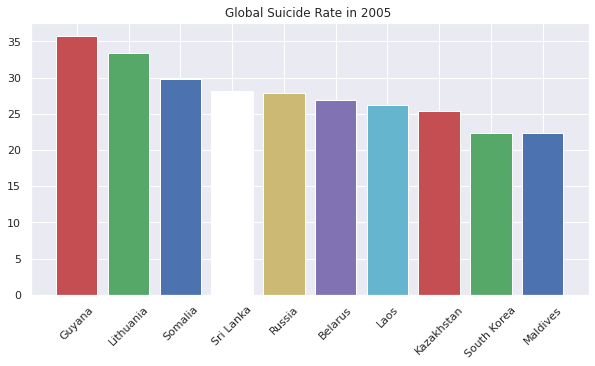

In [213]:
# Show the most suicide rates of 10 countries  in 2005

import seaborn as sns
sns.set()

merge_df = merge_df[['Country','suicideRate']].sort_values(by='suicideRate', ascending=False).head(10)

plt.figure(figsize=(10,5))
 
plt.bar(x=merge_df['Country'],
 
        height=merge_df['suicideRate'],
        
        color='rgbwymc')
 
plt.xticks(rotation=45)
plt.title('Global Suicide Rate in 2005 ', fontsize=12)

# Look at the 'suicide' in Australia

<AxesSubplot:xlabel='Year'>

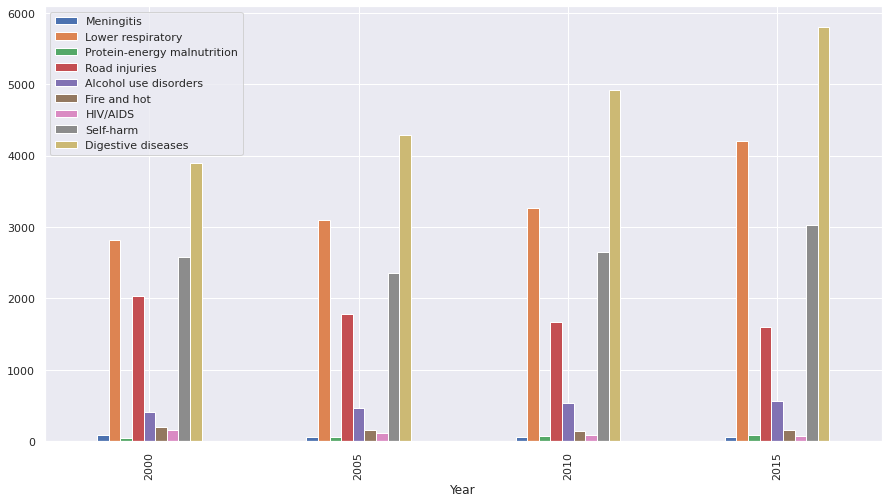

In [214]:
# Draw bar charts for four death causes in Australia in different years
annual_select_AUS = annual_death_causes_less.filter("Entity == 'Australia' AND (Year == '2000' OR Year == '2005' OR Year =='2010' OR Year == '2015')").toPandas()
annual_select_AUS
AUS_Death_df = pd.DataFrame({
    'Year': annual_select_AUS['Year'],
    'Meningitis':annual_select_AUS['Death from meningitis'],
    'Lower respiratory':annual_select_AUS['Death from lower respiratory'],
    'Protein-energy malnutrition':annual_select_AUS['Death from protein-energy malnutrition'],
    'Road injuries':annual_select_AUS['Death from road injuries'],
    'Alcohol use disorders':annual_select_AUS['Death from alcohol use disorders'],
    'Fire and hot': annual_select_AUS['Death from fire and hot'],
    'HIV/AIDS': annual_select_AUS['Death from HIV/AIDS'],
    'Self-harm': annual_select_AUS[ 'Death from self-harm'],
    'Digestive diseases': annual_select_AUS['Death from digestive diseases']
})
  
# plotting graph
AUS_Death_df.plot(x="Year", y=["Meningitis","Lower respiratory","Protein-energy malnutrition", "Road injuries", "Alcohol use disorders", "Fire and hot", "HIV/AIDS", "Self-harm",  'Digestive diseases'], figsize=(15,8), kind="bar")

In conclusion, except several physical diseases, self-harm has big population from all above death causes but it keeps stable.

<AxesSubplot:title={'center':'Suicide rate in Austarlia between 1995 and 2005'}, xlabel='Year'>

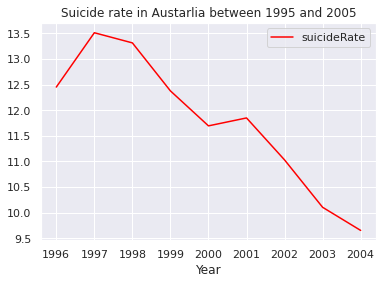

In [215]:
# List suicide rate in Australia between 1995 and 2005
Aus_suicide_df=countrySuicide.select("Year", "suicideRate").filter("Entity == 'Australia' AND Year > 1995 AND Year < 2005").toPandas()

Aus_suicide_df.plot(x='Year', y=['suicideRate'], color='red', title="Suicide rate in Austarlia between 1995 and 2005")

# Suicide rate in Australia by different genders

In [216]:
# List male and female suicide rate in Australia in different years
Aus_female_male_df = yearSuicide.filter("Country == 'Australia'").toPandas()
Aus_female_male_df

,Country,Sex,2016,2015,2010,2000
0,Australia,Both sexes,11.7,12.2,11.0,12.2
1,Australia,Male,17.4,18.3,16.8,19.2
2,Australia,Female,6.0,6.2,5.3,5.4


           Both sexes   Male   Female
In 2000          11.7   17.4      6.0
In 2010          12.2   18.3      6.2
In 2015          11.0   16.8      5.3
In 2016          12.2   19.4      5.4


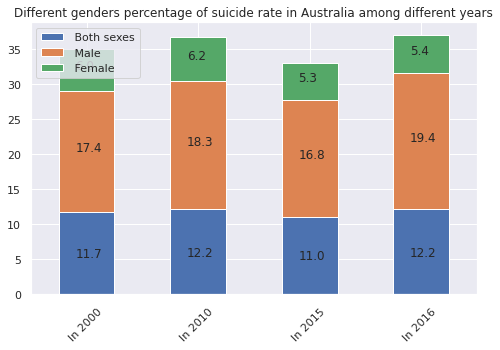

In [217]:
# Load data from previous spark sql result

gender_data = [[ 11.7, 17.4, 6.0 ],
        [ 12.2, 18.3, 6.2],
        [ 11.0, 16.8, 5.3],
        [ 12.2, 19.4, 5.4]]

# Add value in the chart
gender_columns = (' Both sexes', ' Male', ' Female')
df1 = pd.DataFrame(gender_data, columns =gender_columns,index = ['In %d ' % x for x in (2000, 2010, 2015, 2016)])
print(df1)

# Draw stacked bar chart
df_plt1 = df1.plot(kind='bar',stacked=True,figsize=(8,5))

# In this case, there are 12 rectangle objects,
# each whole rectangle relates to each column from ['2000', '2010', '2015', '2016']
def autolabel(rects, data):
    for rect,v in zip(rects[:len(data)], data.values):
        if v[0] != 0:
            plt.text(rect.get_x() + rect.get_width()/2-0.1, 0.45*v[0], '%s' % v[0])
        if v[1] != 0:
            plt.text(rect.get_x() + rect.get_width()/2-0.1, 0.5*(v[1]+2*v[0]), '%s' % v[1])
        if v[2] != 0:
            plt.text(rect.get_x() + rect.get_width()/2-0.1, 0.5*(v[2]+2*(v[1]+v[0])), '%s' % v[2])
    plt.xticks(rotation=45)
    plt.title('Different genders percentage of suicide rate in Australia among different years')

autolabel(df_plt1.get_children(), df1)

In conclusion, in 2000, 2010, 2015 and 2016, the suicide rate of the male tends to be higher than the female in Australia and the suicide rate of the male in 2016 climbed to the top in the gragh. So compared to the female, we need to care more about the male.

# Show suicide rate in Australia by different age groups

+-----+-----+
|  Age|count|
+-----+-----+
|30-49|  286|
| <=29|  192|
|50-69|  201|
| >=70|   58|
+-----+-----+



<AxesSubplot:title={'center':'Global suicide rate by age groups in 2005'}, ylabel='count'>

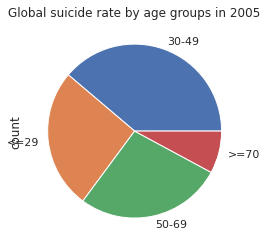

In [218]:
# Show the global distribution of different age groups in 2005
ageGroupSuicide.groupBy("Age").count().show()
#age_suicide_results.show()
#age_df = age_suicide_results.toPandas()
ageGroupSuicide.groupBy("Age").count().toPandas().plot(kind='pie', y='count', labels=age_df['Age'], legend = False, title='Global suicide rate by age groups in 2005')

In [219]:
# Show the Australia's distribution of different age groups among different years
age_suicide_total = spark.sql(" \
    select Year, Age, count(Age) as Suicide_rate_counts \
    from ageGroupSuicide \
    group by Age, Year \
    order by Year asc, Age asc\
                    ")

age_suicide_total.show()

+----+-----+-------------------+
|Year|  Age|Suicide_rate_counts|
+----+-----+-------------------+
|2012|30-49|                 43|
|2012|50-69|                 31|
|2012| <=29|                 26|
|2012| >=70|                 15|
|2013|30-49|                 39|
|2013|50-69|                 38|
|2013| <=29|                 34|
|2013| >=70|                 10|
|2014|30-49|                 49|
|2014|50-69|                 31|
|2014| <=29|                 31|
|2014| >=70|                  6|
|2015|30-49|                 50|
|2015|50-69|                 36|
|2015| <=29|                 38|
|2015| >=70|                  8|
|2016|30-49|                 48|
|2016|50-69|                 35|
|2016| <=29|                 34|
|2016| >=70|                  9|
+----+-----+-------------------+
only showing top 20 rows



          <=29  30-49  50-69  >=70
In 2013     34     39     38    10
In 2014     31     49     31     6
In 2015     38     50     36     8
In 2016     34     48     35     9


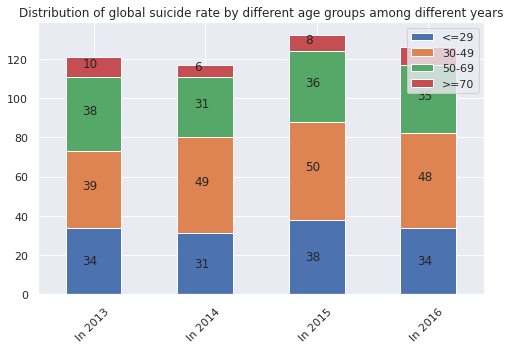

In [220]:
# Load data from previous spark sql result

age_data = [[ 34, 39, 38, 10 ],
        [ 31, 49, 31, 6 ],
        [ 38, 50, 36, 8 ],
        [ 34, 48, 35, 9 ]]

# Add value in the chart
age_columns = ('<=29', '30-49', '50-69', '>=70')
df2 = pd.DataFrame(age_data, columns = age_columns,index = ['In %d ' % x for x in (2013, 2014, 2015, 2016)])
print(df2)

# Draw stacked bar chart
df2_plt = df2.plot(kind='bar',stacked=True,figsize=(8,5))

# In this case, there are 16 rectangle objects,
# each whole rectangle relates to each year from ['2013', '2014', '2015', '2016']
def autolabel(rects, data):
    for rect,v in zip(rects[:len(data)], data.values):
        if v[0] != 0:
            plt.text(rect.get_x() + rect.get_width()/2-0.1, 0.45*v[0], '%s' % v[0])
        if v[1] != 0:
            plt.text(rect.get_x() + rect.get_width()/2-0.1, 0.5*(v[1]+2*v[0]), '%s' % v[1])
        if v[2] != 0:
            plt.text(rect.get_x() + rect.get_width()/2-0.1, 0.5*(v[2]+2*(v[1]+v[0])), '%s' % v[2])
        if v[3] != 0:
            plt.text(rect.get_x() + rect.get_width()/2-0.1, 0.5*(v[3]+2*(v[2]+v[1]+v[0])), '%s' % v[3])
    
    plt.xticks(rotation=45)
    plt.title('Distribution of global suicide rate by different age groups among different years')

autolabel(df2_plt.get_children(), df2)

In conclusion, in 2013, 2014, 2015 and 2016, people with the age of '50-69' tend to want to suicide in Australia. So compaered to other age groups, we should show more concerns to people in 30-49 age in Australia.